In [2]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt

In [3]:
########################################### Funktionen ############################################################################################

def kinetic (circuit, phi):     # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden

    for i in range(n):
        circuit.p(-phi*2**(i+1),i+1)
        for j in range(i+1,n):
            circuit.cx(j+1,0)
            circuit.cx(i+1,0)
            circuit.p(-phi*2**(i+j+1),0)
            circuit.cx(i+1,0)
            circuit.cx(j+1,0)

    return circuit

def timeEv (circuit, q, phi, iterations):      # Zeitentwicklung
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])

    return circuit

In [5]:
########################################### Startparameter ########################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

phi = 0.005
phi = phi/4

# Ortsraumgitter
x_min = -2
x_max = 2
x = np.linspace(x_min, x_max, num=N)

# Gaußsches Wellenpaket als Anfangszustand
mu=-1
sigma = 0.2
psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2))) * np.exp(-65j*x)
psi/= np.sqrt(np.sum(np.abs(psi**2)))       # Normierung auf 1

#plt.plot(x, psi)

In [6]:
########################################### Simulation ###########################################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
c = ClassicalRegister(n)    # Erzeugen eines klassichen Registers, in dem die gemessenen Zustände gespeichert werden
circuit = QuantumCircuit(q,c)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize(psi,q[1:])

simulator = Aer.get_backend('qasm_simulator')   # Festlegen des Simulators, der genutzt werden soll

timeev = []     # Array, in dem die Zwischenschritte gespeichert werden

# Speichern der Anfangsverteilung
temp = circuit.copy()       # temporärer circuit, dessen Endzustand gemessen wird, um Zustandsfunktion von circuit nicht durch Messung zu kollabieren
for j in range(1,n+1):
    temp.measure(j,j-1)
counts = simulator.run(transpile(temp, simulator), shots=5000).result().get_counts()
timeev.append(counts)

# Zeitentwicklung und Messen der Häufigkeitsverteilungen
it = 8
rg = 4       # Anzahl der Durchläufe mit it Iterationen, pro Durchlauf wird die Häufigkeitsverteilung gespeichert

for i in range (rg):
    timeEv(circuit=circuit, q=q, phi=phi, iterations=it)
    temp = circuit.copy()
    for j in range(1,n+1):
        temp.measure(j,j-1)
    counts = simulator.run(transpile(temp, simulator), shots=5000).result().get_counts()
    timeev.append(counts)

In [7]:
########################################### Plots ################################################################################################

# Modifikation, damit im Histogramm auch die Zustände ohne Einträge angezeigt werden

for i in range(N):
  bin = format(i, '0'+str(n)+'b')

  for j in range(len(timeev)):
    if bin not in timeev[j].keys():
      timeev[j][bin] = 0

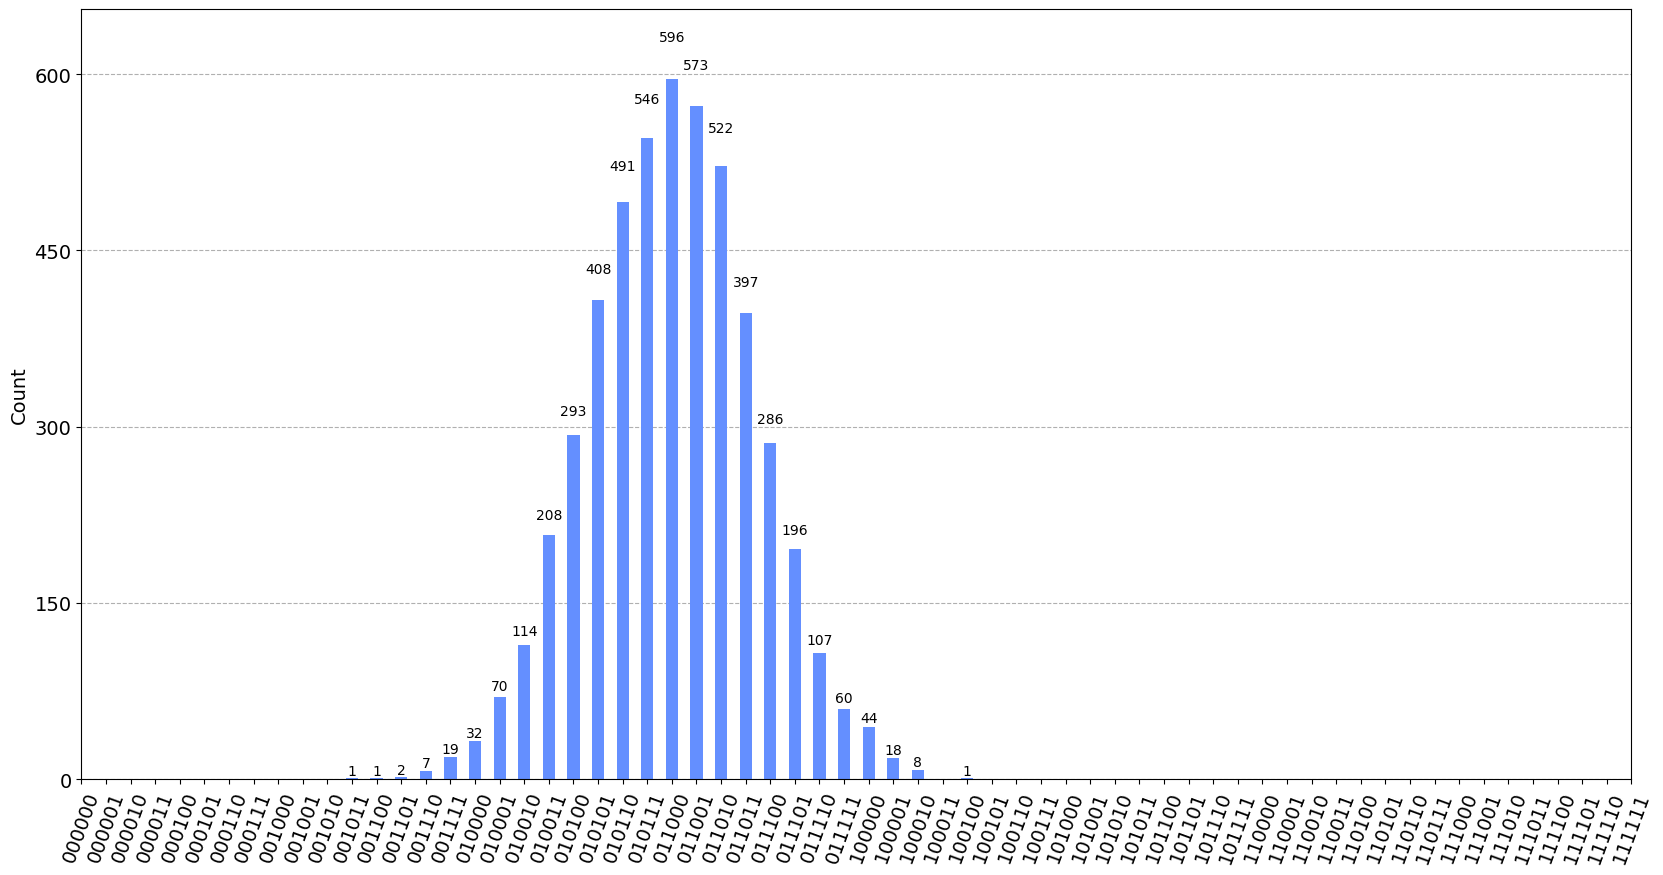

In [13]:
plot_histogram(timeev[2], figsize=[20,10])    # Anzeigen der Histogramme
#plot_histogram(timeev[4], figsize = [20,10], filename='timeev_gauss5_impuls.jpg')   # Speichern der Histogramme 

In [14]:
########################################### Simulation Zustandsvektor ############################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
circuit = QuantumCircuit(q)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize(psi,q[1:])

simulator = Aer.get_backend('statevector_simulator')    # Festlegen des Simulators, hier Zustandsvektor-Simulator

prob_ev = []    # Array, in dem die Zeitentwicklung der Wahrscheinlichkeitsdichte gespeichert wird

# Speichern des Anfangszustandsvektors 
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
prob = statevector.probabilities()
prob = prob[::2]        # Aussortieren der Zustände, in denen das ancilla-Qubit vorkommt
prob_ev.append(prob)

# Simulation der Zustandsvektoren der einzelnen Zeitschritte 
it = 8
rg = 4      # Anzahl der Zeitzwischenschritte die geplottet werden sollen

for i in range(rg):
    timeEv(circuit=circuit, q=q, phi=phi, iterations=it)
    prob = []
    statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
    print(str(i) + ':' + str(statevector.is_valid()))       # Überprüfung ob Zustandsvektor normiert ist, Ausgabe um Fortschritt der Simulation zu verfolgen
    prob = statevector.probabilities()
    prob = prob[::2]
    prob_ev.append(prob)

0:True
1:True
2:True
3:True


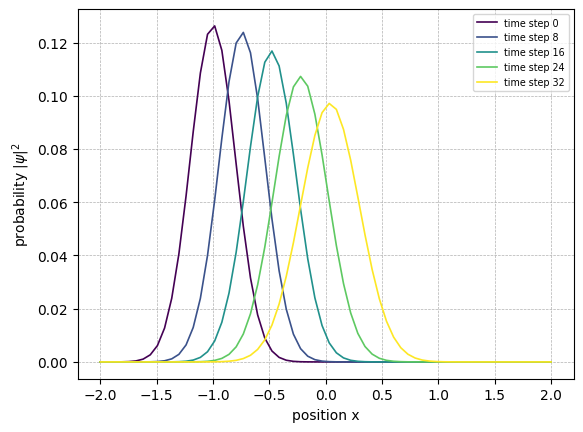

In [17]:
########################################### Plots ################################################################################################

peak_position = []      # Array, in dem die Positionen der Gauß-Kurven gespeichert werden
leg = []    # Array für die Legende

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

for i in range(len(prob_ev)):
    plt.plot(x, prob_ev[i], color=colors[i], linewidth=1.2)
    peak_position.append(x[np.argmax(prob_ev[i])])
    leg.append("time step " + str(i*it))

plt.xlabel('position x')
plt.ylabel(r'probability $|\psi|^2$')
plt.legend(leg, loc='upper right', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_gauss_impuls_anm.jpg', bbox_inches='tight', dpi=300)

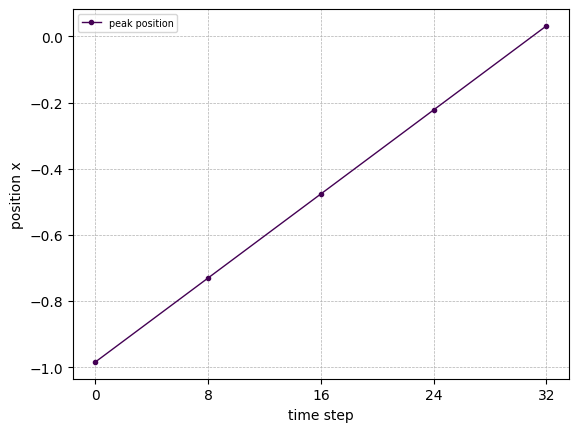

In [18]:
########################################### Peak Positionen ######################################################################################

tsteps = [i*it for i in range(rg+1)]
plt.plot(tsteps, peak_position, marker='.', color=plt.cm.viridis(0), linewidth='1', label='peak position')
plt.xlabel('time step')
plt.ylabel('position x')
plt.xticks(tsteps, tsteps)
plt.legend(loc='upper left', fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

#plt.savefig('timeev_gauss_peakposition.jpg', bbox_inches='tight', dpi=300)